In [1]:
# !kaggle competitions download -c kitchenware-classification
# !mkdir data
# !unzip kitchenware-classification.zip -d data > /dev/null
# !rm kitchenware-classification.zip

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# for EDA
from tensorflow.keras.preprocessing.image import load_img # for example pictures
from tensorflow.keras.preprocessing.image import img_to_array # for example pictures

import matplotlib.pyplot as plt
%matplotlib inline

2022-12-22 08:02:48.806263: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# for CNN from scratch
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# for pre-trained CNN
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

from keras.callbacks import EarlyStopping

In [5]:
df_train_full = pd.read_csv('data/train.csv', dtype = {'Id': str})
df_train_full['filename'] = 'data/images/' + df_train_full['Id'] + '.jpg'
df_train_full.head()

,Id,label,filename
0,0560,glass,data/images/0560.jpg
1,4675,cup,data/images/4675.jpg
2,0875,glass,data/images/0875.jpg
3,4436,spoon,data/images/4436.jpg
4,8265,plate,data/images/8265.jpg


In [6]:
val_cutoff = int(len(df_train_full) * 0.8) # define where to split data into train and validation
df_train = df_train_full[:val_cutoff] # define df_train using cutoff
df_val = df_train_full[val_cutoff:] # define df_val using cutoff

# EDA

<AxesSubplot:ylabel='None'>

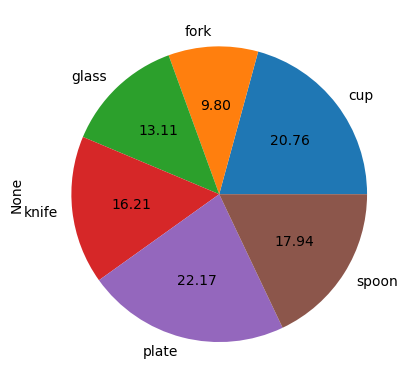

In [7]:
df_train.groupby('label').size().plot(kind='pie', autopct='%.2f')

In [8]:
df_train['label'].value_counts()

plate    986
cup      923
spoon    798
knife    721
glass    583
fork     436
Name: label, dtype: int64

The dataset contains different shares of each of the 6 classes:

22.17% plates (986)

20.76% cups (923)

17.94% spoons (798)

16.21% knives (721)

13.11% glasses (583)

9.8% forks (436)

A quick look into the raw data shows that the image quality (sharpness / resolution) and presentation of contents vary quite substantially. Most items are pictured empty, but some e.g. plates are shown filled with food. In some cases, the item is not completely shown in the picture (i.e. parts of the item are outside of the picture border). 

None of this is a problem per se, as it will make our classifier more robust to new pictures being shot in a "non-standard" fashion.

Some of the provided images are somewhat ambiguous and may "throw off" our model during training. Due to the size of the dataset however, we will not manually review and exclude such cases at this time (see "fork" / "spork" example below).

In [9]:
df_train[df_train.Id=="1075"]

,Id,label,filename
971,1075,fork,data/images/1075.jpg


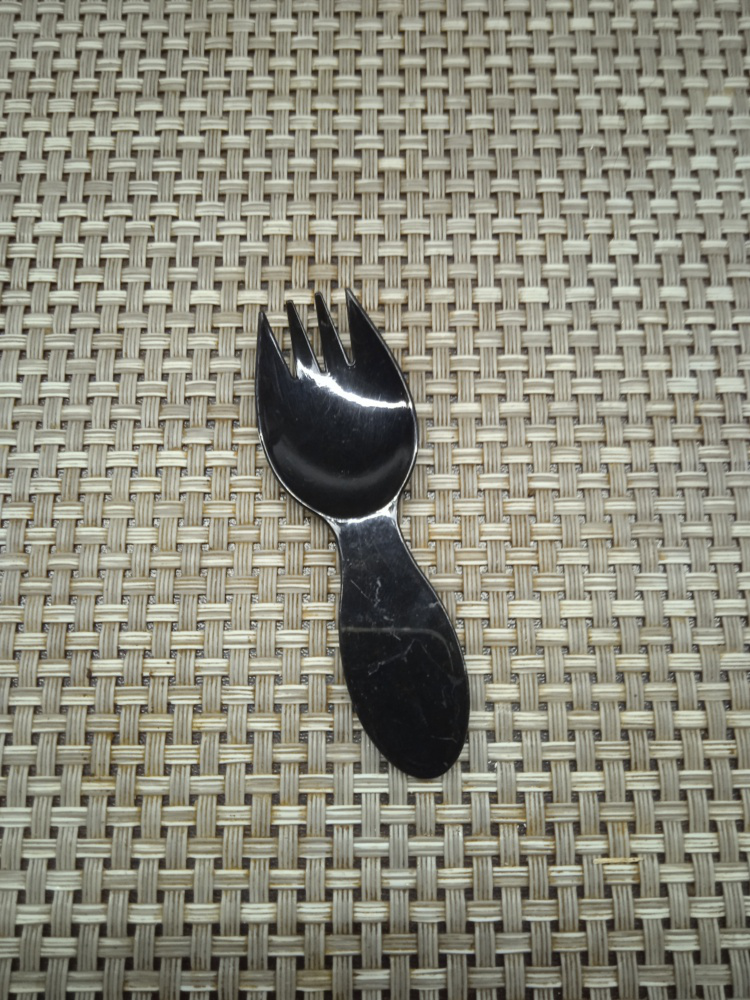

In [10]:
load_img("data/images/1075.jpg")

Of particular interest however is the fact that all objects are shown from various angles. This means that later on, we should be able to significantly improve preliminary model results through **data augmentation** such as **introducing flips and rotations** of the provided images.

# Model training

## Model 1: convolutional neural network from scratch

### Model 1.1: no parameter tuning, no data augmentation

In [11]:
# preliminary: a 1-to-1 copy from hw8

# definitely will need to change:
# - activation method of output layer (6-category classification!!)
# - loss function (binary_crossentropy only for binary classification --> ?)

model = models.Sequential()

model.add(layers.Conv2D(32, # number of filters
                        (3, 3), # kernel size
                        activation='relu', # activation
                        input_shape=(150, 150, 3)) # input shape
         )
model.add(layers.MaxPooling2D((2, 2))) # pooling size
model.add(layers.Flatten()) # turn multi-dim result into vectors
model.add(layers.Dense(64, activation='relu')) # 64-neuron relu-activated dense layer
model.add(layers.Dense(6, activation='softmax')) # 6-neuron output layer; cat. classif. --> softmax

model.compile(loss='categorical_crossentropy',\
              optimizer=optimizers.SGD(learning_rate=0.002, momentum=0.8),\
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 11,216,198
Trainable params: 11,216,198
Non-trainable params: 0
____________________________________________

2022-12-22 08:02:55.453697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 08:02:55.460205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 08:02:55.460861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 08:02:55.461904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [12]:
# rescale color values to 0-1 range
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# No further preprocessing for first run
train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col='filename',
                                                    y_col='label',
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    shuffle=True)
val_generator = val_datagen.flow_from_dataframe(df_val,
                                                x_col='filename',
                                                y_col='label',
                                                target_size=(150, 150),
                                                batch_size=20,
                                                class_mode='categorical',
                                                shuffle=True)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.


In [14]:
# train the model

# only re-run the below on a GPU-enabled instance!!

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator)

Epoch 1/10


2022-12-22 08:02:58.152699: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-22 08:02:58.825275: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-22 08:02:58.825820: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-22 08:02:58.825857: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-22 08:02:58.826464: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-22 08:02:58.826569: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


223/223 [==============================] - 64s 276ms/step - loss: 1.7835 - accuracy: 0.2080 - val_loss: 1.7599 - val_accuracy: 0.2185
Epoch 2/10
223/223 [==============================] - 61s 272ms/step - loss: 1.7236 - accuracy: 0.2712 - val_loss: 1.6784 - val_accuracy: 0.2851
Epoch 3/10
223/223 [==============================] - 61s 273ms/step - loss: 1.6824 - accuracy: 0.2881 - val_loss: 1.6602 - val_accuracy: 0.2869
Epoch 4/10
223/223 [==============================] - 61s 274ms/step - loss: 1.6617 - accuracy: 0.2919 - val_loss: 1.6483 - val_accuracy: 0.2896
Epoch 5/10
223/223 [==============================] - 61s 273ms/step - loss: 1.6416 - accuracy: 0.3009 - val_loss: 1.6306 - val_accuracy: 0.2977
Epoch 6/10
223/223 [==============================] - 61s 274ms/step - loss: 1.6146 - accuracy: 0.3076 - val_loss: 1.5957 - val_accuracy: 0.3031
Epoch 7/10
223/223 [==============================] - 61s 272ms/step - loss: 1.5806 - accuracy: 0.3335 - val_loss: 1.5646 - val_accuracy: 0.3

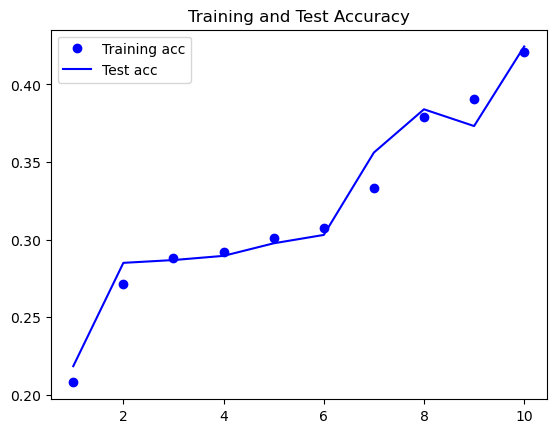

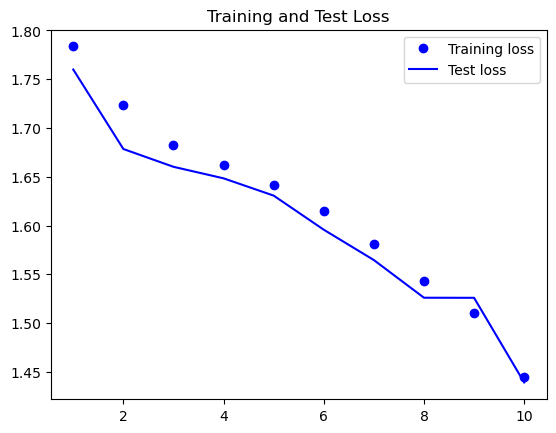

In [15]:
# evaluate training
acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, test_acc, 'b', label='Test acc')
plt.title('Training and Test Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Test Loss')
plt.legend()

plt.show()

We can easily see that both training and validation accuracy are far from plateauing

--> run for another 10 epochs and re-evaluate before saving

In [16]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator)

Epoch 1/10
223/223 [==============================] - 61s 274ms/step - loss: 1.3736 - accuracy: 0.4506 - val_loss: 1.3634 - val_accuracy: 0.4415
Epoch 2/10
223/223 [==============================] - 61s 275ms/step - loss: 1.2951 - accuracy: 0.4898 - val_loss: 1.3593 - val_accuracy: 0.4353
Epoch 3/10
223/223 [==============================] - 61s 274ms/step - loss: 1.2252 - accuracy: 0.5168 - val_loss: 1.2933 - val_accuracy: 0.4757
Epoch 4/10
223/223 [==============================] - 61s 273ms/step - loss: 1.1408 - accuracy: 0.5554 - val_loss: 1.2512 - val_accuracy: 0.5018
Epoch 5/10
223/223 [==============================] - 62s 277ms/step - loss: 1.0481 - accuracy: 0.6085 - val_loss: 1.2310 - val_accuracy: 0.5072
Epoch 6/10
223/223 [==============================] - 61s 275ms/step - loss: 0.9682 - accuracy: 0.6389 - val_loss: 1.1734 - val_accuracy: 0.5360
Epoch 7/10
223/223 [==============================] - 61s 271ms/step - loss: 0.8572 - accuracy: 0.6924 - val_loss: 1.1469 - val_ac

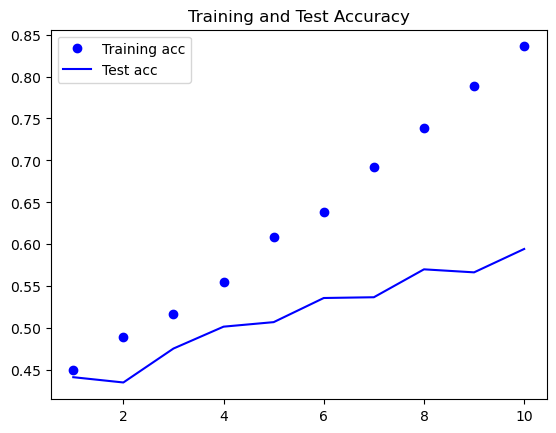

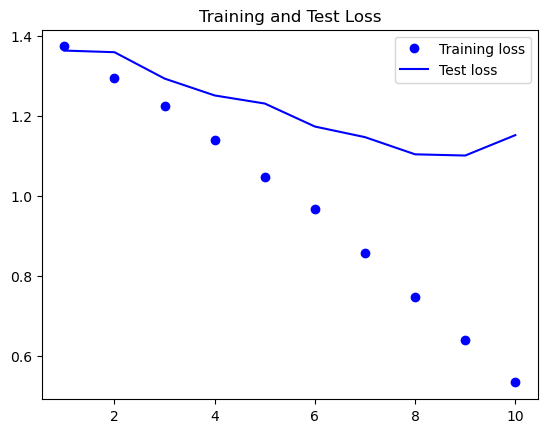

In [17]:
acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, test_acc, 'b', label='Test acc')
plt.title('Training and Test Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Test Loss')
plt.legend()

plt.show()

Validation accuracy now appears to plateau, so let's save the current model and add augmented data for another 20 epochs before we re-reevaluate.

In [18]:
# save pre-augmentation from-scratch CNN model
model.save("cnn_1.1")

INFO:tensorflow:Assets written to: cnn_1.1/assets


INFO:tensorflow:Assets written to: cnn_1.1/assets


### Model 1.2: add data augmentation

In [19]:
# copy-paste from hw8

# Data Augmentation
# For the next two questions, we'll generate more data using data augmentations.
# Add the following augmentations to your training data generator:
# rotation_range=40,
# width_shift_range=0.2,
# height_shift_range=0.2,
# shear_range=0.2,
# zoom_range=0.2,
# horizontal_flip=True,
# fill_mode='nearest'

train_datagen = ImageDataGenerator(rescale=1./255, # don't forget this...
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col='filename',
                                                    y_col='label',
                                                    target_size=(150, 150), 
                                                    batch_size=32, 
                                                    class_mode='categorical')

# val_generator unchanged --> reuse as defined earlier

Found 4447 validated image filenames belonging to 6 classes.


In [20]:
# copy-paste from hw8 ctd -- train 10 additional epochs after data augmentation

history = model.fit(train_generator,
                    epochs=20,
                    validation_data=val_generator)


Epoch 1/20
139/139 [==============================] - 80s 574ms/step - loss: 1.5332 - accuracy: 0.3877 - val_loss: 1.1125 - val_accuracy: 0.5585
Epoch 2/20
139/139 [==============================] - 80s 573ms/step - loss: 1.4779 - accuracy: 0.4079 - val_loss: 1.1261 - val_accuracy: 0.5594
Epoch 3/20
139/139 [==============================] - 79s 572ms/step - loss: 1.4532 - accuracy: 0.4221 - val_loss: 1.1340 - val_accuracy: 0.5567
Epoch 4/20
139/139 [==============================] - 80s 573ms/step - loss: 1.4316 - accuracy: 0.4221 - val_loss: 1.1237 - val_accuracy: 0.5549
Epoch 5/20
139/139 [==============================] - 81s 583ms/step - loss: 1.4344 - accuracy: 0.4243 - val_loss: 1.1374 - val_accuracy: 0.5665
Epoch 6/20
139/139 [==============================] - 79s 571ms/step - loss: 1.4056 - accuracy: 0.4450 - val_loss: 1.1167 - val_accuracy: 0.5459
Epoch 7/20
139/139 [==============================] - 79s 570ms/step - loss: 1.4072 - accuracy: 0.4347 - val_loss: 1.1834 - val_ac

In [21]:
acc_aug = history.history['accuracy']
test_acc_aug = history.history['val_accuracy']
loss_aug = history.history['loss']
test_loss_aug = history.history['val_loss']

epochs_aug = range(1, len(acc_aug) + 1)

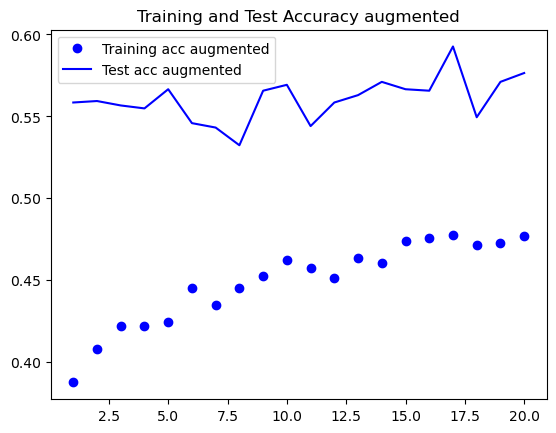

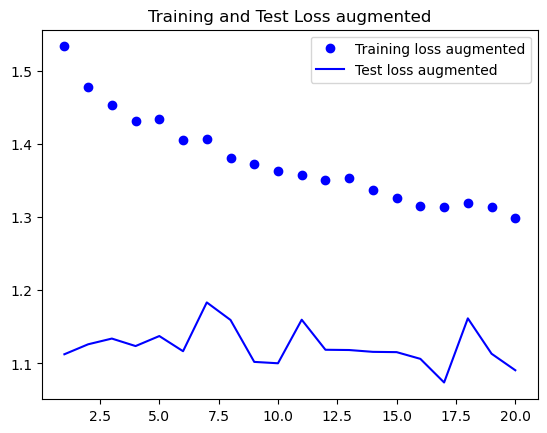

In [22]:
# evaluation of 20 additional epochs after data augmentation

plt.plot(epochs_aug, acc_aug, 'bo', label='Training acc augmented')
plt.plot(epochs_aug, test_acc_aug, 'b', label='Test acc augmented')
plt.title('Training and Test Accuracy augmented')
plt.legend()

plt.figure()

plt.plot(epochs_aug, loss_aug, 'bo', label='Training loss augmented')
plt.plot(epochs_aug, test_loss_aug, 'b', label='Test loss augmented')
plt.title('Training and Test Loss augmented')
plt.legend()

plt.show()

Still exhibits what I would consider some room for brute-force improvement. Add 20 epochs with re-augmented data.

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255, # don't forget this...
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col='filename',
                                                    y_col='label',
                                                    target_size=(150, 150), 
                                                    batch_size=32, 
                                                    class_mode='categorical')

# val_generator unchanged --> reuse as defined earlier

Found 4447 validated image filenames belonging to 6 classes.


In [24]:
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=val_generator)


Epoch 1/20
139/139 [==============================] - 81s 586ms/step - loss: 1.2893 - accuracy: 0.4920 - val_loss: 1.0986 - val_accuracy: 0.5782
Epoch 2/20
139/139 [==============================] - 81s 584ms/step - loss: 1.2955 - accuracy: 0.4819 - val_loss: 1.1103 - val_accuracy: 0.5549
Epoch 3/20
139/139 [==============================] - 81s 586ms/step - loss: 1.2911 - accuracy: 0.4947 - val_loss: 1.1088 - val_accuracy: 0.5603
Epoch 4/20
139/139 [==============================] - 81s 582ms/step - loss: 1.2770 - accuracy: 0.4958 - val_loss: 1.0676 - val_accuracy: 0.5845
Epoch 5/20
139/139 [==============================] - 81s 584ms/step - loss: 1.2719 - accuracy: 0.4940 - val_loss: 1.0881 - val_accuracy: 0.5809
Epoch 6/20
139/139 [==============================] - 81s 583ms/step - loss: 1.2683 - accuracy: 0.4949 - val_loss: 1.0754 - val_accuracy: 0.5890
Epoch 7/20
139/139 [==============================] - 82s 590ms/step - loss: 1.2722 - accuracy: 0.5001 - val_loss: 1.0876 - val_ac

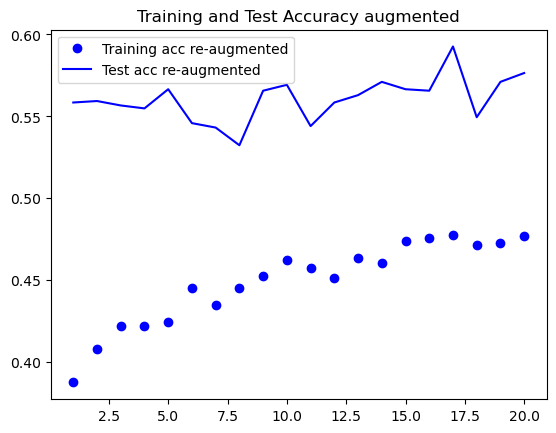

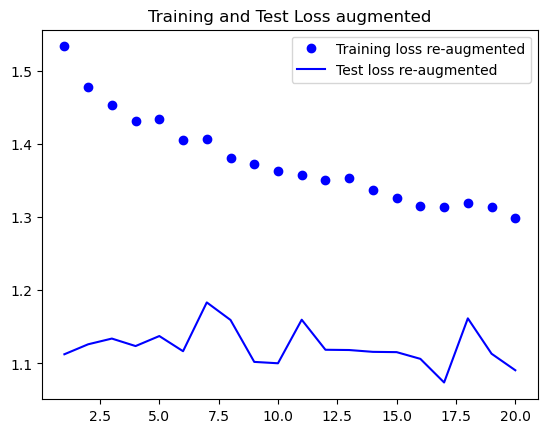

In [25]:
# plot for last 20 of 10 + 10 + 20 (augmented) + 20 (re-augmented) = 60 total epochs of training

plt.plot(epochs_aug, acc_aug, 'bo', label='Training acc re-augmented')
plt.plot(epochs_aug, test_acc_aug, 'b', label='Test acc re-augmented')
plt.title('Training and Test Accuracy augmented')
plt.legend()

plt.figure()

plt.plot(epochs_aug, loss_aug, 'bo', label='Training loss re-augmented')
plt.plot(epochs_aug, test_loss_aug, 'b', label='Test loss re-augmented')
plt.title('Training and Test Loss augmented')
plt.legend()

plt.show()

Unfortunately this model -- without tuning any parameters for now -- appears to "top out" at a validation accuracy of about 0.6. Since the starter notebook solution using xception scores much higher (around 0.85), we will focus next on improving the result of the exception model by simply adding augmented data to the same.

For completeness, we will nonetheless save this intermediate model version.

In [26]:
model.save("cnn_1.2")

INFO:tensorflow:Assets written to: cnn_1.2/assets


INFO:tensorflow:Assets written to: cnn_1.2/assets


### Model 1.3 Extending the initial CNN and adding dropout
The initial model had 11 million tunable parameters. In order not to make training time explode, we will try to not overcomplicate the model with dropout either.

We introduce a 20% dropout before the first hidden layer. Learning rate and momentum are increased similarly to an example found under

https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

In [27]:
model = models.Sequential()

model.add(layers.Conv2D(32, # number of filters
                        (3, 3), # kernel size
                        activation='relu', # activation
                        input_shape=(150, 150, 3)) # input shape
         )
model.add(layers.MaxPooling2D((2, 2))) # pooling size
model.add(layers.Flatten()) # turn multi-dim result into vectors
model.add(layers.Dropout(0.2)) # <-- here we add a 20% dropout layer
# it is added directly after reading and formatting the input layer = before the first hidden layer
model.add(layers.Dense(64, activation='relu')) # 64-neuron relu-activated dense layer
model.add(layers.Dense(6, activation='softmax')) # 6-neuron output layer; cat. classif. --> softmax

model.compile(loss='categorical_crossentropy',\
              optimizer=optimizers.SGD(learning_rate=0.02, momentum=0.9),\
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 175232)            0         
                                                                 
 dropout (Dropout)           (None, 175232)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                11214912  
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                      

In [28]:
# train this model for 10 epochs, review, augment data, run another 10 epochs
# return to "basic rescaler"
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col='filename',
                                                    y_col='label',
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    shuffle=True)
val_generator = val_datagen.flow_from_dataframe(df_val,
                                                x_col='filename',
                                                y_col='label',
                                                target_size=(150, 150),
                                                batch_size=20,
                                                class_mode='categorical',
                                                shuffle=True)
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.
Epoch 1/10
223/223 [==============================] - 64s 285ms/step - loss: 1.7753 - accuracy: 0.2653 - val_loss: 1.6381 - val_accuracy: 0.3633
Epoch 2/10
223/223 [==============================] - 64s 285ms/step - loss: 1.5583 - accuracy: 0.3625 - val_loss: 1.4507 - val_accuracy: 0.4074
Epoch 3/10
223/223 [==============================] - 63s 284ms/step - loss: 1.4768 - accuracy: 0.4104 - val_loss: 1.4411 - val_accuracy: 0.3912
Epoch 4/10
223/223 [==============================] - 62s 277ms/step - loss: 1.5622 - accuracy: 0.3665 - val_loss: 1.7675 - val_accuracy: 0.2203
Epoch 5/10
223/223 [==============================] - 62s 279ms/step - loss: 1.7598 - accuracy: 0.2139 - val_loss: 1.7767 - val_accuracy: 0.2167
Epoch 6/10
223/223 [==============================] - 62s 278ms/step - loss: 1.7597 - accuracy: 0.2130 - val_loss: 1.7712 - val_accuracy: 0.1906
Epoch 7/

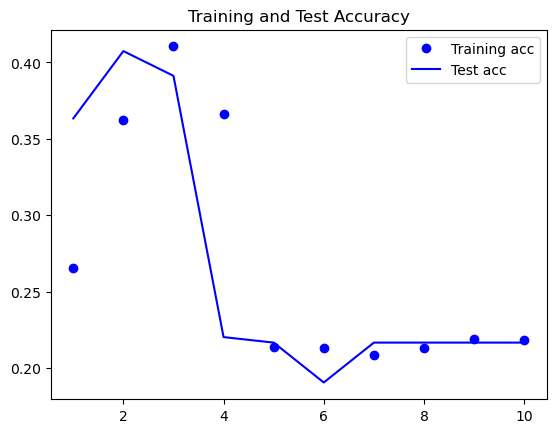

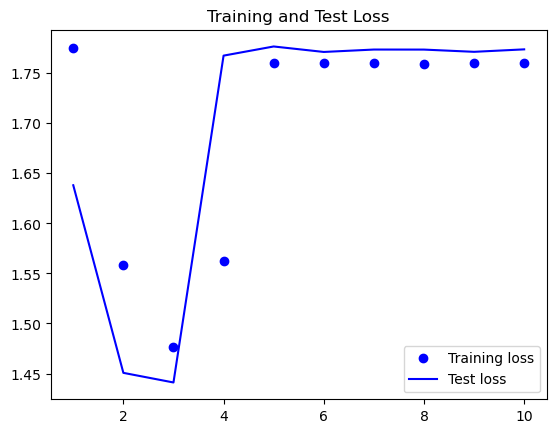

In [29]:
acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, test_acc, 'b', label='Test acc')
plt.title('Training and Test Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Test Loss')
plt.legend()

plt.show()

In [30]:
train_datagen = ImageDataGenerator(rescale=1./255, # don't forget this...
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col='filename',
                                                    y_col='label',
                                                    target_size=(150, 150), 
                                                    batch_size=32, 
                                                    class_mode='categorical')

# val_generator unchanged --> reuse as defined earlier

Found 4447 validated image filenames belonging to 6 classes.


In [31]:
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator)

Epoch 1/10
139/139 [==============================] - 81s 585ms/step - loss: 1.7593 - accuracy: 0.2217 - val_loss: 1.7726 - val_accuracy: 0.2167
Epoch 2/10
139/139 [==============================] - 81s 583ms/step - loss: 1.7590 - accuracy: 0.2143 - val_loss: 1.7711 - val_accuracy: 0.2167
Epoch 3/10
139/139 [==============================] - 81s 586ms/step - loss: 1.7597 - accuracy: 0.2217 - val_loss: 1.7719 - val_accuracy: 0.2167
Epoch 4/10
139/139 [==============================] - 82s 587ms/step - loss: 1.7588 - accuracy: 0.2177 - val_loss: 1.7721 - val_accuracy: 0.2167
Epoch 5/10
139/139 [==============================] - 82s 588ms/step - loss: 1.7595 - accuracy: 0.2195 - val_loss: 1.7729 - val_accuracy: 0.1906
Epoch 6/10
139/139 [==============================] - 81s 586ms/step - loss: 1.7589 - accuracy: 0.2183 - val_loss: 1.7754 - val_accuracy: 0.2167
Epoch 7/10
139/139 [==============================] - 81s 587ms/step - loss: 1.7594 - accuracy: 0.2177 - val_loss: 1.7723 - val_ac

In [32]:
acc_aug = history.history['accuracy']
test_acc_aug = history.history['val_accuracy']
loss_aug = history.history['loss']
test_loss_aug = history.history['val_loss']

epochs_aug = range(1, len(acc_aug) + 1)

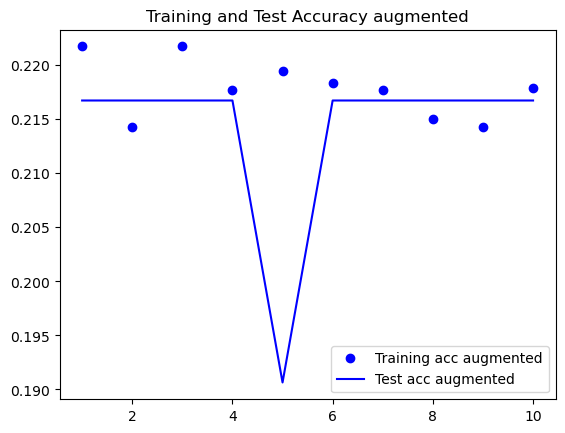

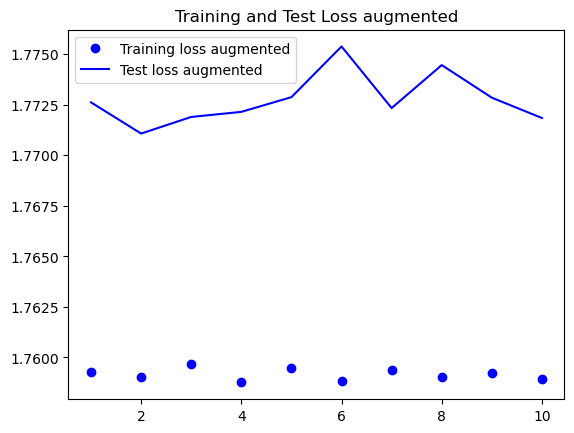

In [33]:
plt.plot(epochs_aug, acc_aug, 'bo', label='Training acc augmented')
plt.plot(epochs_aug, test_acc_aug, 'b', label='Test acc augmented')
plt.title('Training and Test Accuracy augmented')
plt.legend()

plt.figure()

plt.plot(epochs_aug, loss_aug, 'bo', label='Training loss augmented')
plt.plot(epochs_aug, test_loss_aug, 'b', label='Test loss augmented')
plt.title('Training and Test Loss augmented')
plt.legend()

plt.show()

~~**Adding** 20% **dropout** before the first hidden layer in the from-scratch CNN **improves test accuracy by around 3 percentage points to 0.63 before augmentation**. However, when running the model otherwise unchanged (no longer included in this notebook), overfitting was evident already after a few epochs. ~~

~~While adjusting learning rate and momentum appears to address this problem quite well, validation accuracy now no longer manages to surpass 0.5 (at least after training for only 10 epochs).~~

_Upon re-running the above cells for consistency of results, unfortunately it was not possible to recreate the above described outcomes. This issue will need to be reviewed in detail later on._

Data augmentation or training for additional epochs were not explored at this time.

The model remains far behind the benchmark model from the keras starter notebook. This is what we will focus on next.

In [34]:
model.save("cnn_1.3")

INFO:tensorflow:Assets written to: cnn_1.3/assets


INFO:tensorflow:Assets written to: cnn_1.3/assets


## Model 2: pre-trained convolutional neural network (xception) 

In [35]:
train_xc_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_xc_generator = train_xc_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(299, 299),
    batch_size=32
)

val_xc_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_xc_generator = val_xc_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(299, 299),
    batch_size=32
)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.


In [36]:
X, y = next(train_xc_generator)

In [37]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)
)

base_model.trainable = False

inputs = keras.Input(shape=(299, 299, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(6)(vectors)

model = keras.Model(inputs, outputs)

In [38]:
learning_rate = 0.01

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer = optimizer,
              loss = loss, 
              metrics=['accuracy'])

In [39]:
history = model.fit(train_xc_generator,
                    epochs = 10, 
                    validation_data = val_xc_generator)

Epoch 1/10
139/139 [==============================] - 79s 548ms/step - loss: 0.2258 - accuracy: 0.9247 - val_loss: 0.1507 - val_accuracy: 0.9478
Epoch 2/10
139/139 [==============================] - 73s 528ms/step - loss: 0.1081 - accuracy: 0.9645 - val_loss: 0.1450 - val_accuracy: 0.9532
Epoch 3/10
139/139 [==============================] - 73s 527ms/step - loss: 0.0845 - accuracy: 0.9732 - val_loss: 0.3125 - val_accuracy: 0.9173
Epoch 4/10
139/139 [==============================] - 73s 527ms/step - loss: 0.0795 - accuracy: 0.9762 - val_loss: 0.1573 - val_accuracy: 0.9532
Epoch 5/10
139/139 [==============================] - 73s 527ms/step - loss: 0.0517 - accuracy: 0.9838 - val_loss: 0.1612 - val_accuracy: 0.9505
Epoch 6/10
139/139 [==============================] - 73s 525ms/step - loss: 0.0357 - accuracy: 0.9908 - val_loss: 0.1541 - val_accuracy: 0.9514
Epoch 7/10
139/139 [==============================] - 73s 526ms/step - loss: 0.0415 - accuracy: 0.9876 - val_loss: 0.1905 - val_ac

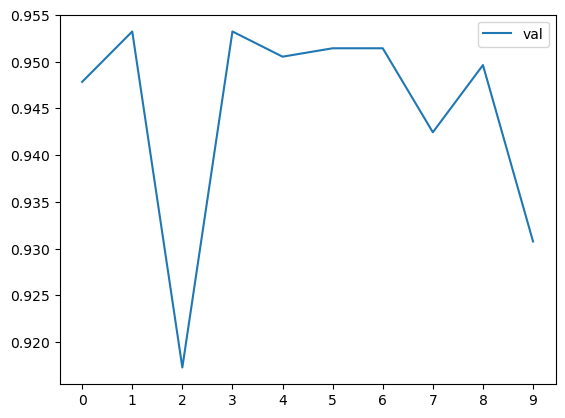

In [40]:
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

The approach of reusing the pre-trained 299x299x3 xception model is looking extremely promising.

However, the baseline approach above appears to suffer from overfitting: the training accuracy is close to 1 while test accuracy stays close to but below 0.95.

As in the lecture, now check if changing the learning rate can improve validation accuracy.

In [41]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(299, 299, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(299, 299, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(6)(vectors) # we have 6 possible categories
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [42]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_xc_generator, epochs=10, validation_data=val_xc_generator)
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10
139/139 [==============================] - 77s 537ms/step - loss: 1.3781 - accuracy: 0.6060 - val_loss: 0.9722 - val_accuracy: 0.8615
Epoch 2/10
139/139 [==============================] - 72s 520ms/step - loss: 0.7706 - accuracy: 0.8968 - val_loss: 0.5938 - val_accuracy: 0.9272
Epoch 3/10
139/139 [==============================] - 73s 523ms/step - loss: 0.5169 - accuracy: 0.9274 - val_loss: 0.4279 - val_accuracy: 0.9371
Epoch 4/10
139/139 [==============================] - 72s 514ms/step - loss: 0.3958 - accuracy: 0.9357 - val_loss: 0.3407 - val_accuracy: 0.9388
Epoch 5/10
139/139 [==============================] - 73s 523ms/step - loss: 0.3274 - accuracy: 0.9397 - val_loss: 0.2885 - val_accuracy: 0.9451
Epoch 6/10
139/139 [==============================] - 71s 511ms/step - loss: 0.2838 - accuracy: 0.9431 - val_loss: 0.2533 - val_accuracy: 0.9469
Epoch 7/10
139/139 [==============================] - 72s 518ms/step - loss: 0.2532 - accuracy: 0.9465 - val_loss: 0.2279 -

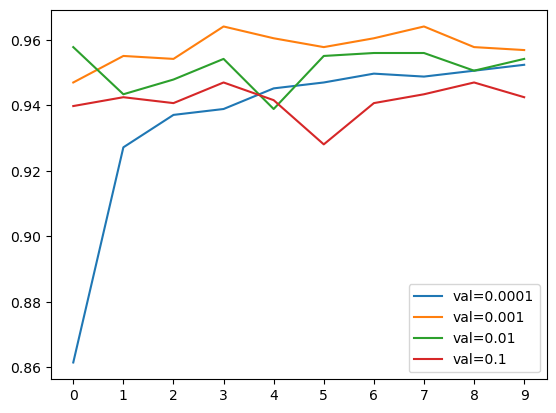

In [43]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()


With a..

- learning rate of 0.0001, val_accuracy does not reach 0.95 in 10 epochs

- learning rate of 0.001, we get 0.956 val_accuracy, almost 0.96

- learning rate of 0.01 or 0.1, we actually observe val_accuracy decreasing over time 

--> the best choice for learning rate in this situation is 0.001

--> re-run with optimal learning rate and save candidate model

--> then train for another 10 epochs on augmented data to see if it improves validation accuracy

In [44]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)
)

base_model.trainable = False

inputs = keras.Input(shape=(299, 299, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(6)(vectors)

model = keras.Model(inputs, outputs)

learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer = optimizer,
              loss = loss, 
              metrics=['accuracy'])

# simple early stopping as soon as we exceed 0.96 validation accuracy
es = EarlyStopping(monitor='val_accuracy', mode='min', baseline=0.970)

history = model.fit(train_xc_generator,
                    epochs = 10, 
                    validation_data = val_xc_generator,
                    callbacks=[es])

Epoch 1/10
139/139 [==============================] - 77s 533ms/step - loss: 0.4288 - accuracy: 0.8943 - val_loss: 0.1759 - val_accuracy: 0.9532
Epoch 2/10
139/139 [==============================] - 71s 513ms/step - loss: 0.1666 - accuracy: 0.9548 - val_loss: 0.1365 - val_accuracy: 0.9577


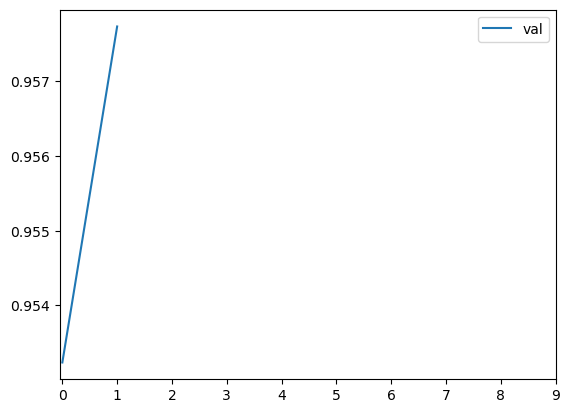

In [45]:
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

In [46]:
# save candidate (best learning rate as identified above)
# 2.1 = xception-based CNN, already with "best" learning rate 
# but before augmentation and/or other parameter tuning
model.save("cnn_2.1")

INFO:tensorflow:Assets written to: cnn_2.1/assets


INFO:tensorflow:Assets written to: cnn_2.1/assets


In [47]:
# following 3 cells markdown-ed

train_xc_datagen_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                          rotation_range=40,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          horizontal_flip=True)

train_xc_generator_aug = train_xc_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(299, 299),
    batch_size=32
)

history = model.fit(train_xc_generator_aug,
                    epochs = 10, 
                    validation_data = val_xc_generator)

plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

In [48]:
# remember to save if better than cnn_2.1 model

In [49]:
# create kaggle submission with best performing model variant

In [50]:
# model = keras.models.load_model('cnn_2.1')

In [51]:
df_test = pd.read_csv('data/test.csv', dtype = {'Id': str})
df_test['filename'] = 'data/images/' + df_test['Id'] + '.jpg'
df_test.head()

,Id,filename
0,0678,data/images/0678.jpg
1,3962,data/images/3962.jpg
2,9271,data/images/9271.jpg
3,5133,data/images/5133.jpg
4,8842,data/images/8842.jpg


In [52]:
test_xc_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_xc_generator = test_xc_datagen.flow_from_dataframe(
    df_test,
    x_col='filename',
    class_mode='input',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)


Found 3808 validated image filenames.


In [53]:
y_pred = model.predict(test_xc_generator)

119/119 [==============================] - 55s 458ms/step


In [54]:
classes = np.array(list(train_xc_generator.class_indices.keys()))


In [55]:
classes

array(['cup', 'fork', 'glass', 'knife', 'plate', 'spoon'], dtype='<U5')

In [56]:
predictions = classes[y_pred.argmax(axis=1)]

In [57]:
df_submission = pd.DataFrame()

df_submission['filename'] = test_xc_generator.filenames
df_submission['label'] = predictions
df_submission['Id'] = df_submission.filename.str[len('data/images/'):-4]

del df_submission['filename']

df_submission[['Id', 'label']].to_csv('submission.csv', index=False)

In [58]:
# !kaggle competitions submit kitchenware-classification -f submission.csv -m 'validation accuracy: 0.957'

The last submitted model is the best-performing so far. We will use this approach to continue working towards deployment.

In [59]:
classes

array(['cup', 'fork', 'glass', 'knife', 'plate', 'spoon'], dtype='<U5')

In [60]:
img = load_img("data/images/2222.jpg", target_size=(299, 299))

x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
preds


1/1 [==============================] - 1s 873ms/step


array([[-5.5298996, -1.3847171, -5.2704964, -3.2197185, -3.9579892,
         4.731273 ]], dtype=float32)